In [1]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [2]:
name = '30_ieee'
SOFT_CONN = True
ordmat, ordlist, buslist, countlist = lp.pow_parser(name)
ordmat = torch.tensor(ordmat)

In [3]:
alpha = 0.001
niter = 200000
min_change = 0.05
update_steps = 3

niter_sampling = 100000

## REFERENCE

In [6]:
class MySamplerFiveStats(MHSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, ac, avg_degree, avg_clustering]))

betas = torch.tensor([0., 0., 0., 0., 0.], dtype=float)


sampler_five_stats = MySamplerFiveStats(backend="cuda")

obs_five_stats = sampler_five_stats.observables(ordmat)

params_five_stats, _ = sampler_five_stats.param_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 200000/200000 [04:22<00:00, 763.03it/s] 

number of accepted steps is:  46444
number of rejected samples:  153556
number of effective updates is:  15481


In [7]:
params_for_estimates = torch.stack(params_five_stats[-100:]).mean(axis = 0)

observables_five_stats, graphs_five_stats = sampler_five_stats.sample_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=params_for_estimates,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 100000/100000 [02:15<00:00, 739.75it/s]

number of accepted steps is:  20012
number of rejected samples:  79988
Mean obs:  tensor([44.0224,  7.9329,  0.0758,  2.9348,  0.1291], dtype=torch.float64)


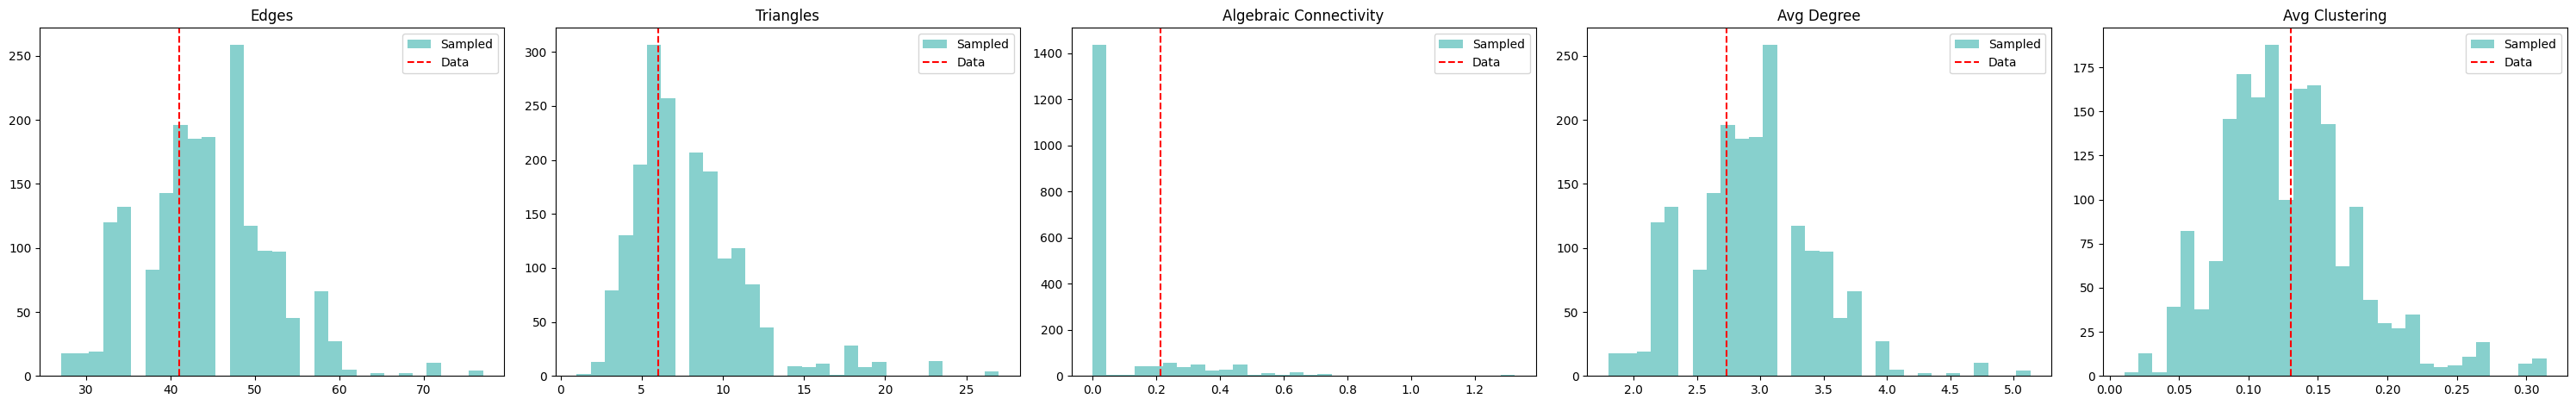

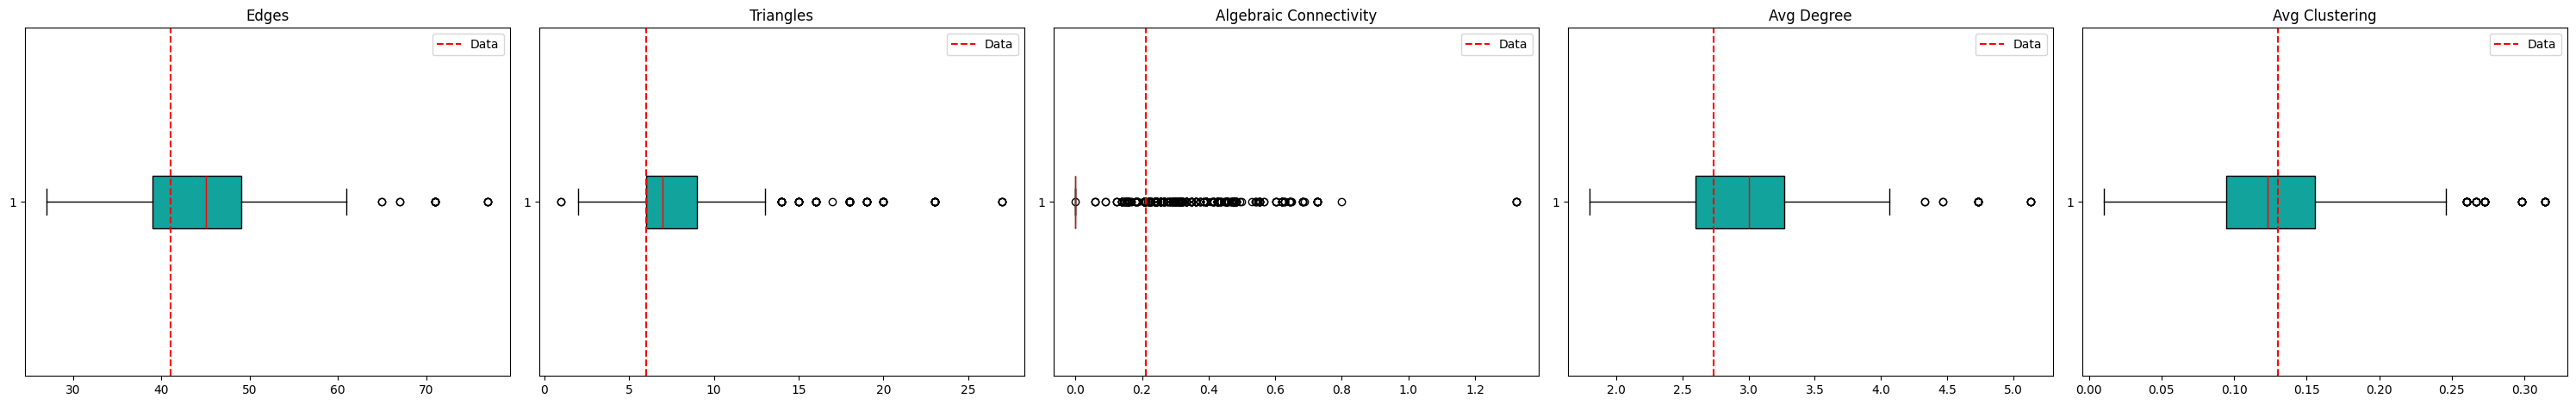

In [8]:
hist_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])
boxplot_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

## Toggling connectivity

connectivity parameter x10

In [28]:
mod_on_connectivity = torch.tensor([1., 1., 10., 1., 1.], dtype=float)

In [29]:
new_params = params_for_estimates * mod_on_connectivity
new_observables, new_graphs = sampler_five_stats.sample_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=new_params,
                      niter=niter_sampling,
                      save_every=50)

  0%|          | 18/100000 [00:00<09:15, 179.89it/s]

100%|██████████| 100000/100000 [01:54<00:00, 876.41it/s]

number of accepted steps is:  30380
number of rejected samples:  69620
Mean obs:  tensor([71.5787, 19.3484,  1.2099,  4.7719,  0.0999], dtype=torch.float64)


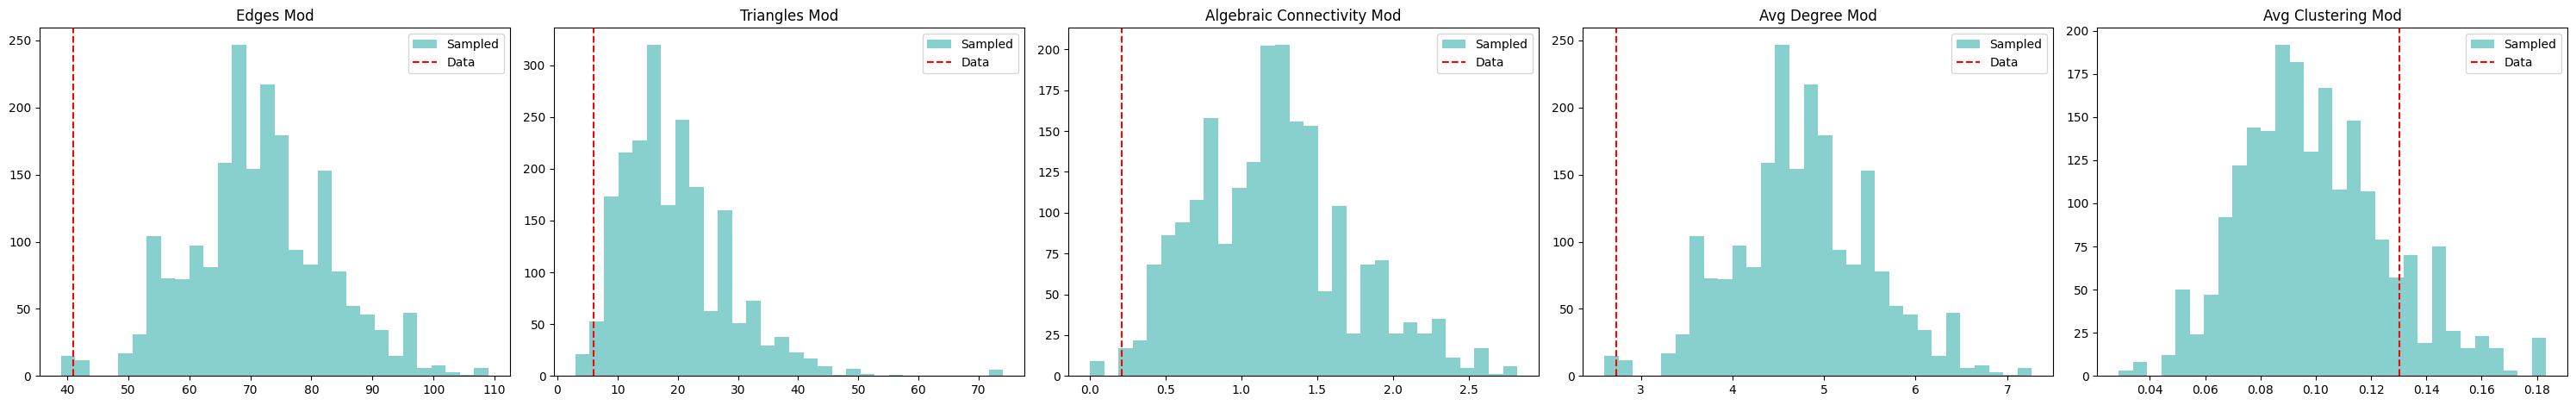

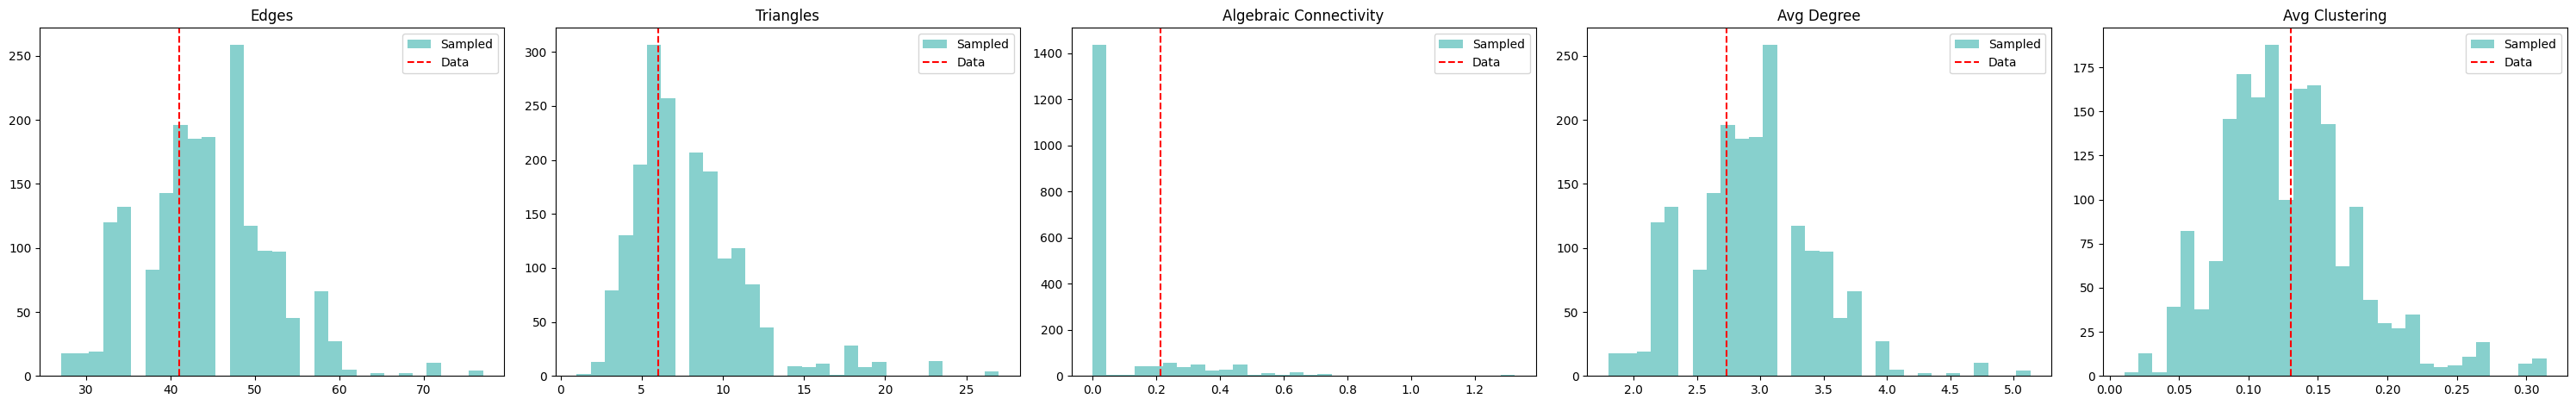

In [38]:
hist_obs_samples(new_observables, obs_five_stats, obs_labels = ['Edges Mod', 'Triangles Mod', 'Algebraic Connectivity Mod', 'Avg Degree Mod', 'Avg Clustering Mod'])
hist_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

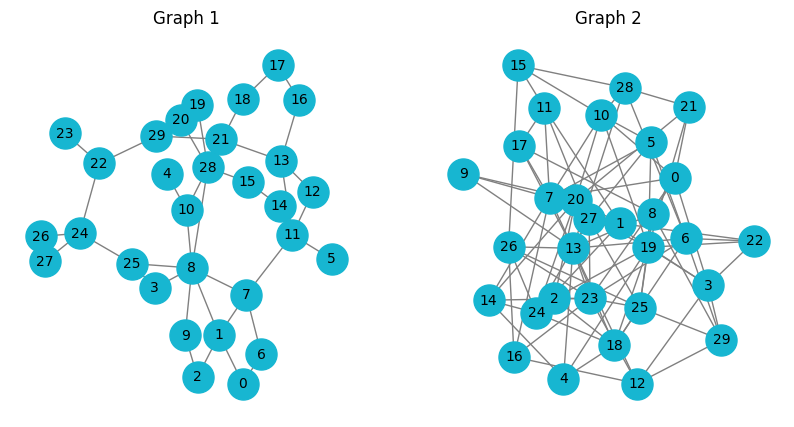

In [54]:
compare_graphs(ordmat, new_graphs[rnd.randint(0, len(new_graphs)-1)], labels=True)

---

## Toggling number of edges

parameter on number of edges x0.001

In [41]:
mod_on_edges = torch.tensor([0.001, 1., 1., 1., 1.], dtype=float)

In [42]:
new_params2 = params_for_estimates * mod_on_edges
new_observables2, new_graphs2 = sampler_five_stats.sample_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=new_params2,
                      niter=niter_sampling,
                      save_every=50)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:28<00:00, 671.90it/s]

number of accepted steps is:  34703
number of rejected samples:  65297
Mean obs:  tensor([3.5886e+02, 2.2994e+03, 1.8601e+01, 2.3924e+01, 4.1349e-01],
       dtype=torch.float64)


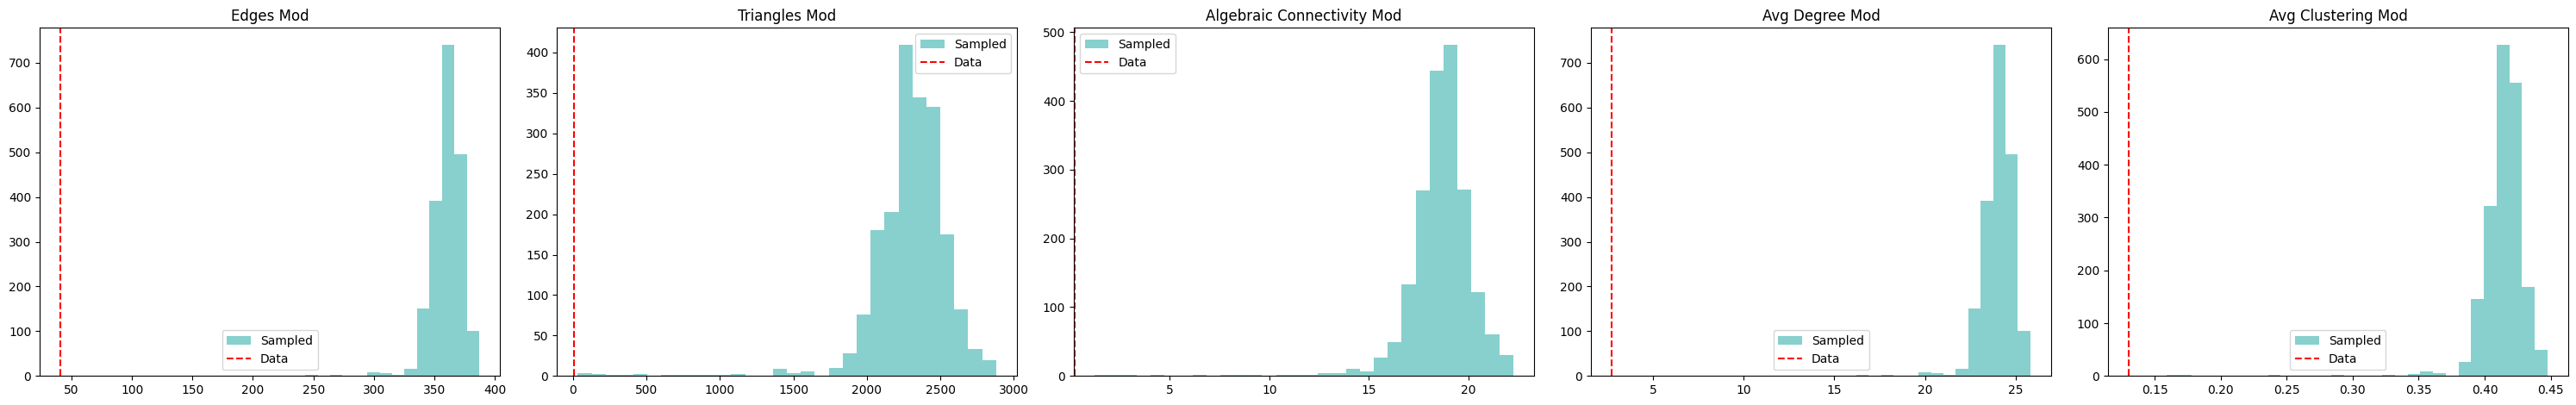

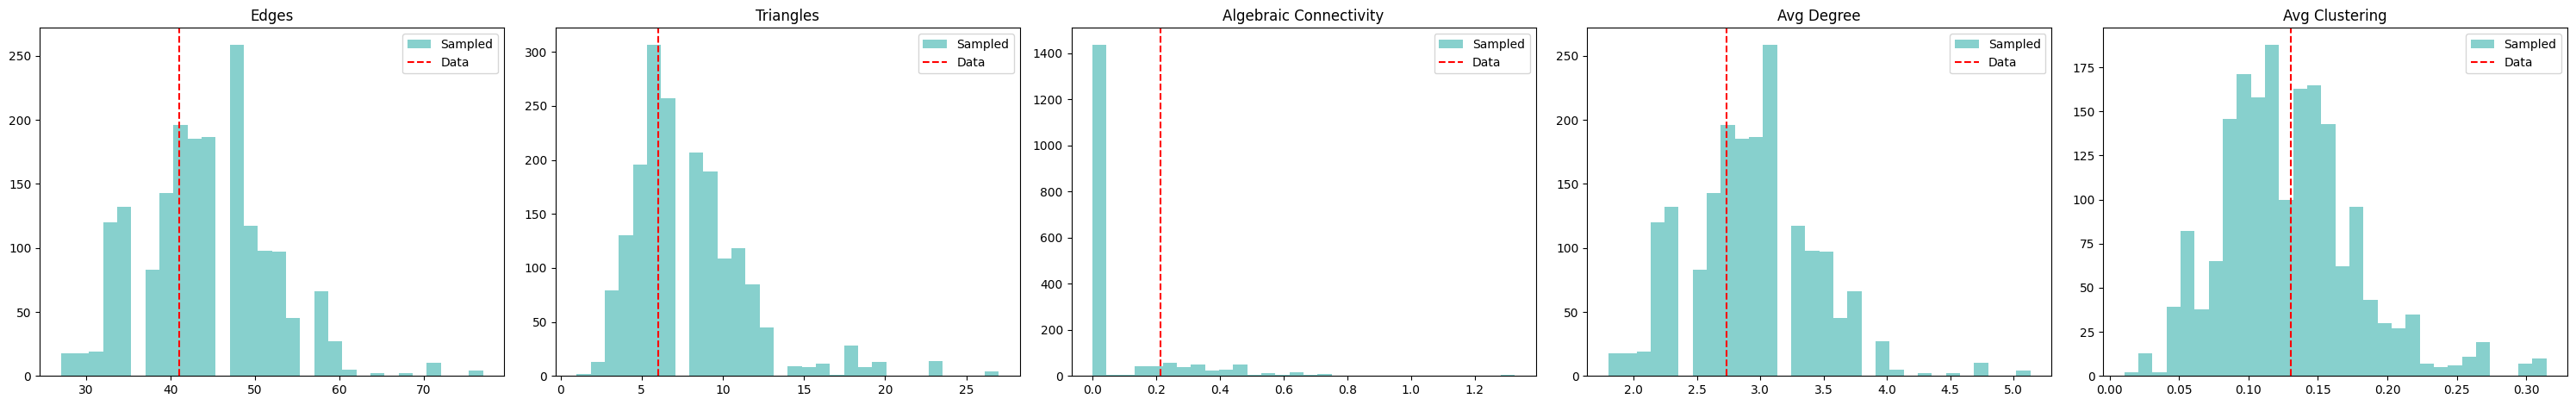

In [43]:
hist_obs_samples(new_observables2, obs_five_stats, obs_labels = ['Edges Mod', 'Triangles Mod', 'Algebraic Connectivity Mod', 'Avg Degree Mod', 'Avg Clustering Mod'])
hist_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

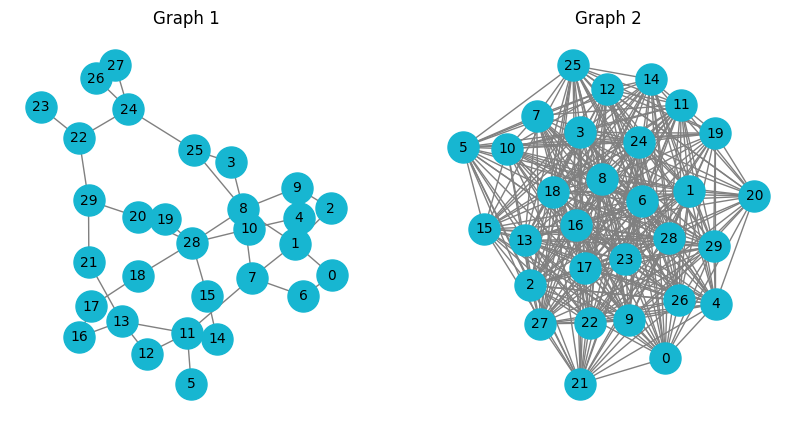

In [65]:
compare_graphs(ordmat, new_graphs2[rnd.randint(0, len(new_graphs2)-1)], labels=True)

---

## Toggling both alebraic connectivity and number of triangles

ac x10, triangles x10

In [80]:
mod3 = torch.tensor([1., 1., 10, 1, 10.], dtype=float)

In [81]:
new_params3 = params_for_estimates * mod3
new_observables3, new_graphs3 = sampler_five_stats.sample_run(graph=ordmat,
                      observables=obs_five_stats,
                      params=new_params3,
                      niter=niter_sampling,
                      save_every=50)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:10<00:00, 1422.24it/s]

number of accepted steps is:  1566
number of rejected samples:  98434
Mean obs:  tensor([ 2.2524e+01,  9.7373e+00, -6.4063e-16,  1.5016e+00,  4.9431e-01],
       dtype=torch.float64)


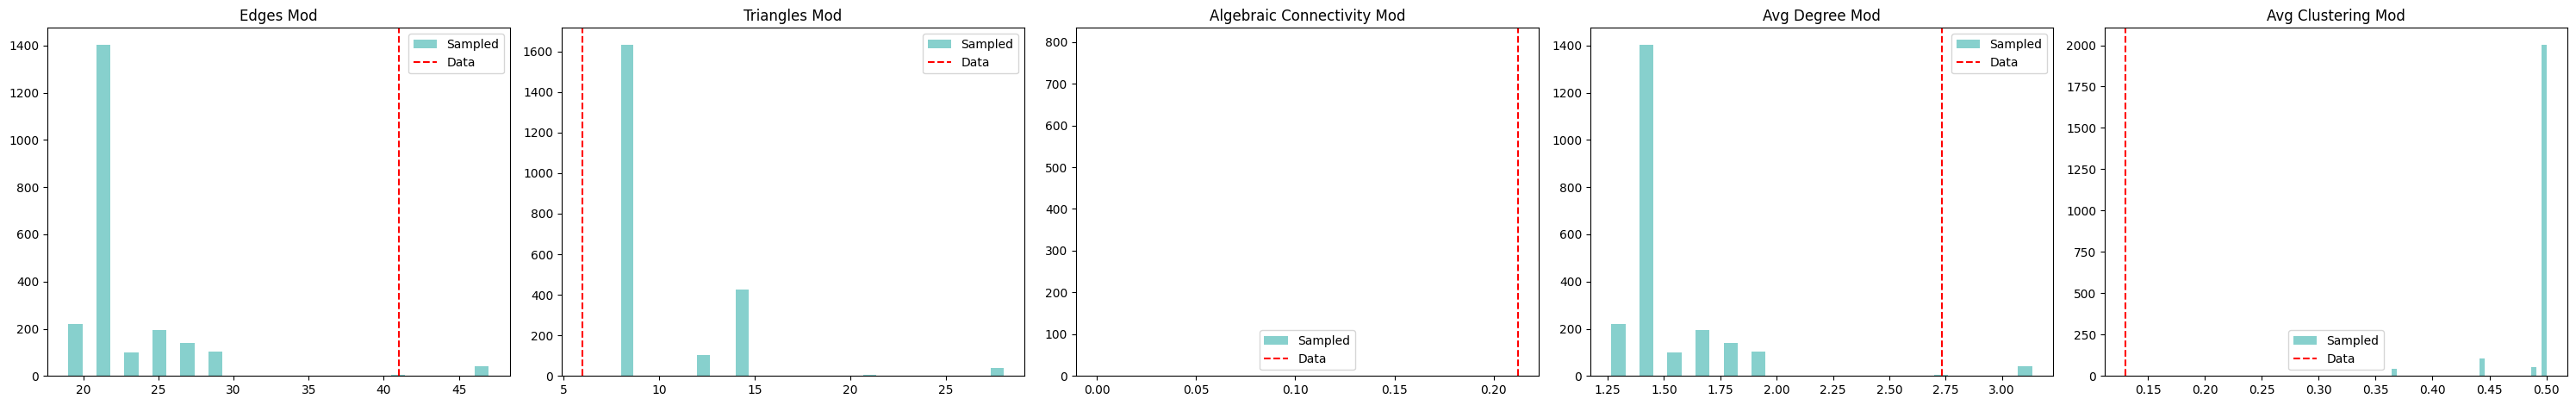

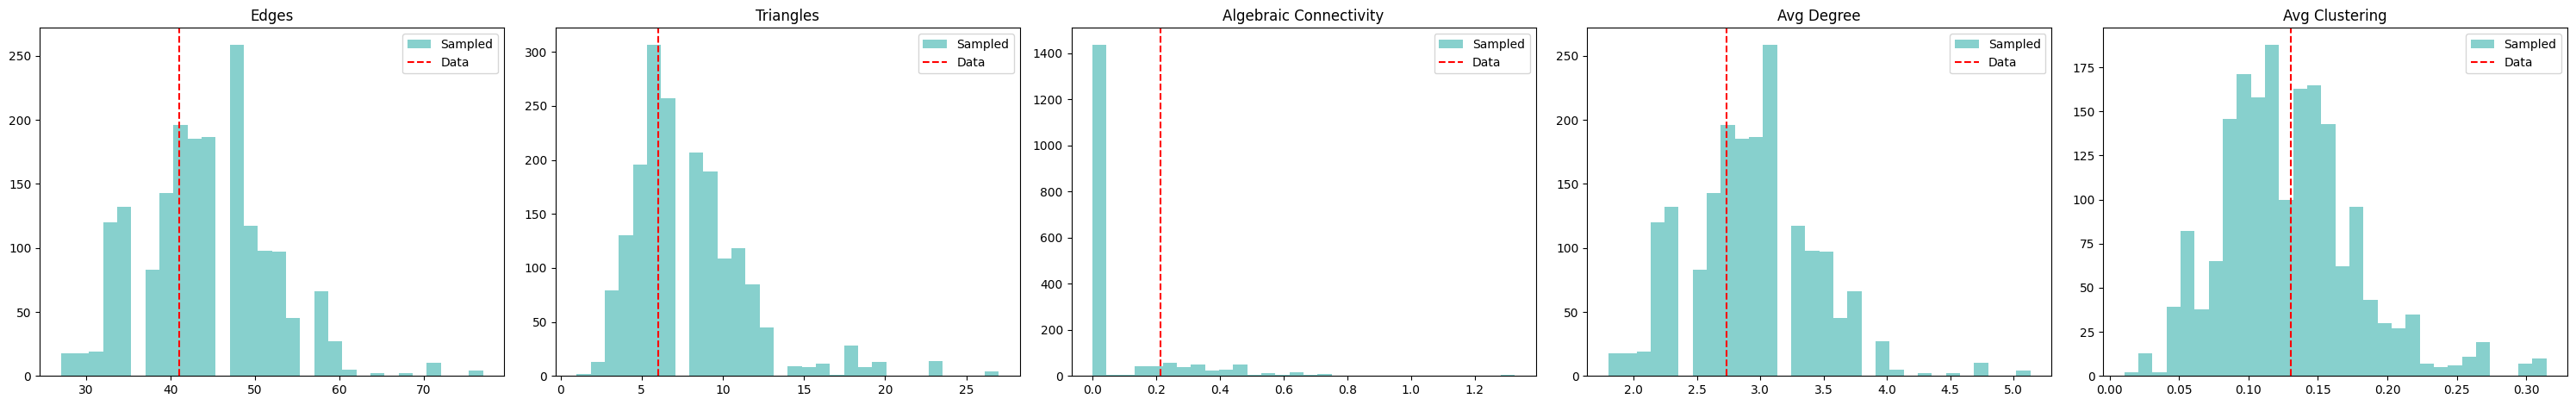

In [82]:
hist_obs_samples(new_observables3, obs_five_stats, obs_labels = ['Edges Mod', 'Triangles Mod', 'Algebraic Connectivity Mod', 'Avg Degree Mod', 'Avg Clustering Mod'])
hist_obs_samples(observables_five_stats, obs_five_stats, obs_labels = ['Edges', 'Triangles', 'Algebraic Connectivity', 'Avg Degree', 'Avg Clustering'])

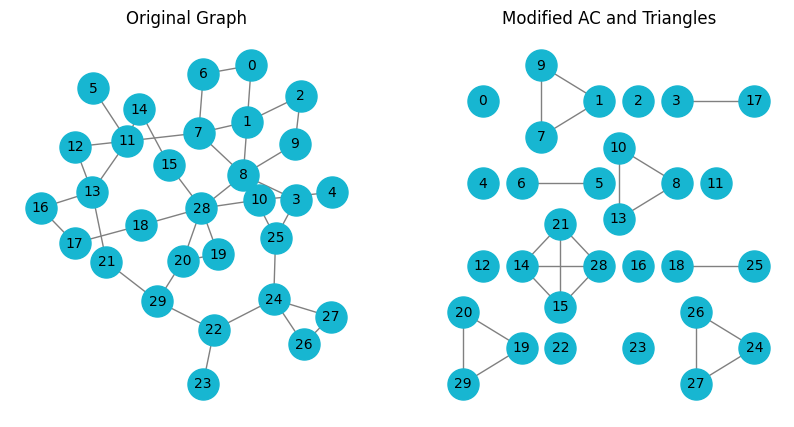

In [90]:
compare_graphs(ordmat, new_graphs3[rnd.randint(0, len(new_graphs3)-1)], labels=True, layout1='kamada', layout2='kamada_grid', title1="Original Graph", title2="Modified AC and Triangles")